In [1]:
!pip install PyMuPDF
!pip install sentence-transformers
!pip install scikit-learn


In [2]:
import fitz
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer, CrossEncoder

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

In [5]:
pdf_path = '/content/infi_cpntext.pdf'

In [6]:
pdf_text = extract_text_from_pdf(pdf_path)

In [7]:

documents = re.split(r'\n{2,}|\.\s|\?\s|\!\s', pdf_text)

In [8]:
documents = [doc for doc in documents if doc.strip()]

In [9]:
document_embeddings = embedding_model.encode(documents)


In [10]:
query = "Explain the concept of Infini-attention."
query_embedding = embedding_model.encode(query)

## 1. Embedding-Based Retrieval

In [11]:
cosine_similarities = cosine_similarity([query_embedding], document_embeddings)[0]

In [12]:
print("Documents ranked by similarity:")
sorted_indices = np.argsort(cosine_similarities)[::-1]
for idx in sorted_indices[:5]:  # Display top 5 results
    print(f"Document: {documents[idx]}, Similarity: {cosine_similarities[idx]:.4f}")

Documents ranked by similarity:
Document: We call such an efficient attention mechanism
Infini-attention, which is illustrated in Figure 1 and described formally in the following
sections, Similarity: 0.8232
Document: A key
component in our proposed approach is a new attention technique dubbed Infini-attention
(Figure 1), Similarity: 0.7686
Document: 3.1
Infini-attention
As shown Figure 1, our Infini-attention is a recurrent attention mechanism that computes
both local and global context states and combine them for its output, Similarity: 0.7220
Document: A key component in our proposed approach is a new at-
tention technique dubbed Infini-attention, Similarity: 0.7007
Document: The Infini-attention incorporates a compressive memory into the vanilla attention
mechanism (Bahdanau et al., 2014; Vaswani et al., 2017) and builds in both masked local
attention and long-term linear attention mechanisms in a single Transformer block, Similarity: 0.6722


# 2. Similarity Search with KNN using Matplotlib

In [13]:
nbrs = NearestNeighbors(n_neighbors=3, metric='cosine').fit(document_embeddings)
distances, indices = nbrs.kneighbors([query_embedding])

In [14]:
retrieved_embeddings = document_embeddings[indices[0]]

In [15]:
pca = PCA(n_components=2)
projected_dataset_embeddings = pca.fit_transform(document_embeddings)
projected_query_embedding = pca.transform([query_embedding])
projected_retrieved_embeddings = pca.transform(retrieved_embeddings)

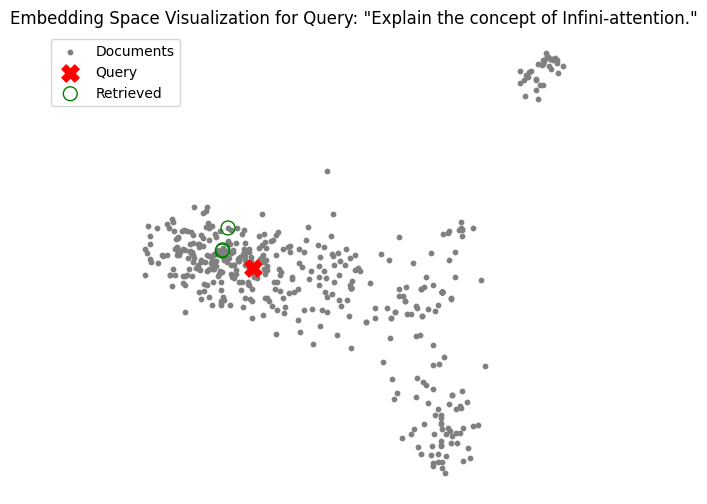

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray', label='Documents')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='red', label='Query')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='green', label='Retrieved')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'Embedding Space Visualization for Query: "{query}"')
plt.legend()
plt.axis('off')
plt.show()

# 3. Query Expansion

In [17]:
expanded_query = "Infini-attention mechanism in transformers"
expanded_query_embedding = embedding_model.encode(expanded_query)

In [18]:
expanded_cosine_similarities = cosine_similarity([expanded_query_embedding], document_embeddings)[0]

In [19]:
print("\nExpanded Query Results:")
sorted_expanded_indices = np.argsort(expanded_cosine_similarities)[::-1]
for idx in sorted_expanded_indices[:5]:  # Display top 5 results
    print(f"Document: {documents[idx]}, Similarity: {expanded_cosine_similarities[idx]:.4f}")


Expanded Query Results:
Document: The Infini-attention incorporates
a compressive memory into the vanilla attention mechanism and builds
in both masked local attention and long-term linear attention mechanisms
in a single Transformer block, Similarity: 0.7868
Document: The Infini-attention incorporates a compressive memory into the vanilla attention
mechanism (Bahdanau et al., 2014; Vaswani et al., 2017) and builds in both masked local
attention and long-term linear attention mechanisms in a single Transformer block, Similarity: 0.7792
Document: So each attention layer of Infini-Transformers has both global
compressive and local fine-grained states, Similarity: 0.7033
Document: We call such an efficient attention mechanism
Infini-attention, which is illustrated in Figure 1 and described formally in the following
sections, Similarity: 0.6904
Document: The attention mechanism in Transformers ex-
hibits quadratic complexity in both memory
footprint and computation time, Similarity: 0.667

# 4. Cross-Encoder Re-Ranking

In [20]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-6')

In [21]:
cross_encoder_scores = cross_encoder.predict([[query, doc] for doc in documents])

In [22]:
print("\nDocuments ranked by Cross-Encoder Re-Ranking:")
sorted_cross_encoder_indices = np.argsort(cross_encoder_scores)[::-1]
for idx in sorted_cross_encoder_indices[:5]:  # Display top 5 results
    print(f"Document: {documents[idx]}, Score: {cross_encoder_scores[idx]:.4f}")


Documents ranked by Cross-Encoder Re-Ranking:
Document: Infini-attention introduces minimal change to the standard scaled dot-product atten-
tion and supports plug-and-play continual pre-training and long-context adaptation
by design, Score: 0.9715
Document: The proposed Infini-attention addresses those issues by enabling a segment-
level streaming computation over long sequences with a fixed local attention window, Score: 0.9676
Document: The Infini-attention incorporates
a compressive memory into the vanilla attention mechanism and builds
in both masked local attention and long-term linear attention mechanisms
in a single Transformer block, Score: 0.9510
Document: 3.1
Infini-attention
As shown Figure 1, our Infini-attention is a recurrent attention mechanism that computes
both local and global context states and combine them for its output, Score: 0.9250
Document: Our Infini-attention reuses all the key, value and query states of the standard attention
computation for long-term memo

#Embedding Adapter

In [23]:
import torch
import torch.nn as nn

In [24]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [25]:
class EmbeddingAdapter(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EmbeddingAdapter, self).__init__()
        self.adapter = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.adapter(x)

In [26]:
input_dim = 384  # Dimension of the 'all-MiniLM-L6-v2' embeddings
output_dim = 384  # Output dimension can be the same or different
embedding_adapter = EmbeddingAdapter(input_dim, output_dim)

In [27]:
document_embeddings = embedding_model.encode(documents)
query_embedding = embedding_model.encode(query)

In [28]:
document_embeddings_tensor = torch.tensor(document_embeddings)
query_embedding_tensor = torch.tensor(query_embedding).unsqueeze(0)

In [29]:
adapted_document_embeddings = embedding_adapter(document_embeddings_tensor)
adapted_query_embedding = embedding_adapter(query_embedding_tensor)

In [30]:
adapted_document_embeddings_np = adapted_document_embeddings.detach().numpy()
adapted_query_embedding_np = adapted_query_embedding.detach().numpy()

In [31]:
pca = PCA(n_components=2)
projected_dataset_embeddings = pca.fit_transform(document_embeddings)
projected_query_embedding = pca.transform([query_embedding])
projected_adapted_query_embedding = pca.transform(adapted_query_embedding_np)
projected_adapted_document_embeddings = pca.transform(adapted_document_embeddings_np)

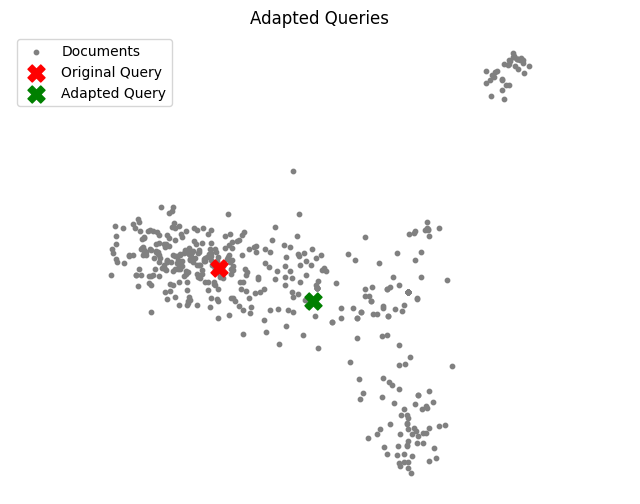

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray', label='Documents')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='red', label='Original Query')
plt.scatter(projected_adapted_query_embedding[:, 0], projected_adapted_query_embedding[:, 1], s=150, marker='X', color='green', label='Adapted Query')

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()
plt.show()